In [9]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

In [10]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)

print(df.shape)
df.head()

(3925, 17)


,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend,btc_log_return,active_addresses_pct_change,trend_diff,btc_rsi,eth_log_return,sp500_log_return,gold_log_return,dxy_log_return
2014-09-17,457.334015,160989.0,84.699997,NaN,NaN,1234.400024,0.09,2001.569946,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,160989.0,84.320000,NaN,NaN,1225.699951,0.09,2011.359985,22.0,-0.074643,0.000000,0.0,NaN,NaN,0.004879,-0.007073,-0.004496
2014-09-19,394.795990,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.072402,-0.111355,0.0,NaN,NaN,-0.000477,-0.008521,0.005676
2014-09-20,408.903992,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,0.035111,0.000000,0.0,NaN,NaN,0.000000,0.000000,0.000000
2014-09-21,398.821014,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.024968,0.000000,0.0,NaN,NaN,0.000000,0.000000,0.000000


Construcción del modelo

In [11]:
def datasets(dataset, target, regresores=[]):
    df = dataset[[target] + regresores].dropna().copy()
    df = df.reset_index().rename(columns={'index': 'ds', target: 'y'})
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    return df, train_df, test_df

In [12]:
def plot_prophet(data, test, model,plot_name="", regresores=[]):
    future = data[['ds'] + regresores]


    forecast = model.predict(future)

    forecast_test = forecast.set_index('ds').loc[test['ds']]
    y_true = test['y'].values
    y_pred = forecast_test['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"📊 MAE Prophet:  {mae:.6f}")
    print(f"📊 RMSE Prophet: {rmse:.6f}")

    # 6. Gráfico: predicción vs real
    plt.figure(figsize=(14, 6))
    plt.plot(test['ds'], y_true, label='Real (Test)', color='blue')
    plt.plot(test['ds'], y_pred, label='Predicción (Prophet)', color='orange')
    plt.fill_between(test['ds'], y_true, y_pred, color='gray', alpha=0.3, label='Error')
    plt.title('Predicción vs Real (Test Set, Prophet)')
    plt.xlabel('Fecha')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if plot_name != "":
        plt.savefig(f"../img/{plot_name}", dpi=300)
    plt.show()

Comenzaré usando el retorno logarítmico

13:37:58 - cmdstanpy - INFO - Chain [1] start processing
13:37:58 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE Prophet:  0.017746
📊 RMSE Prophet: 0.025197


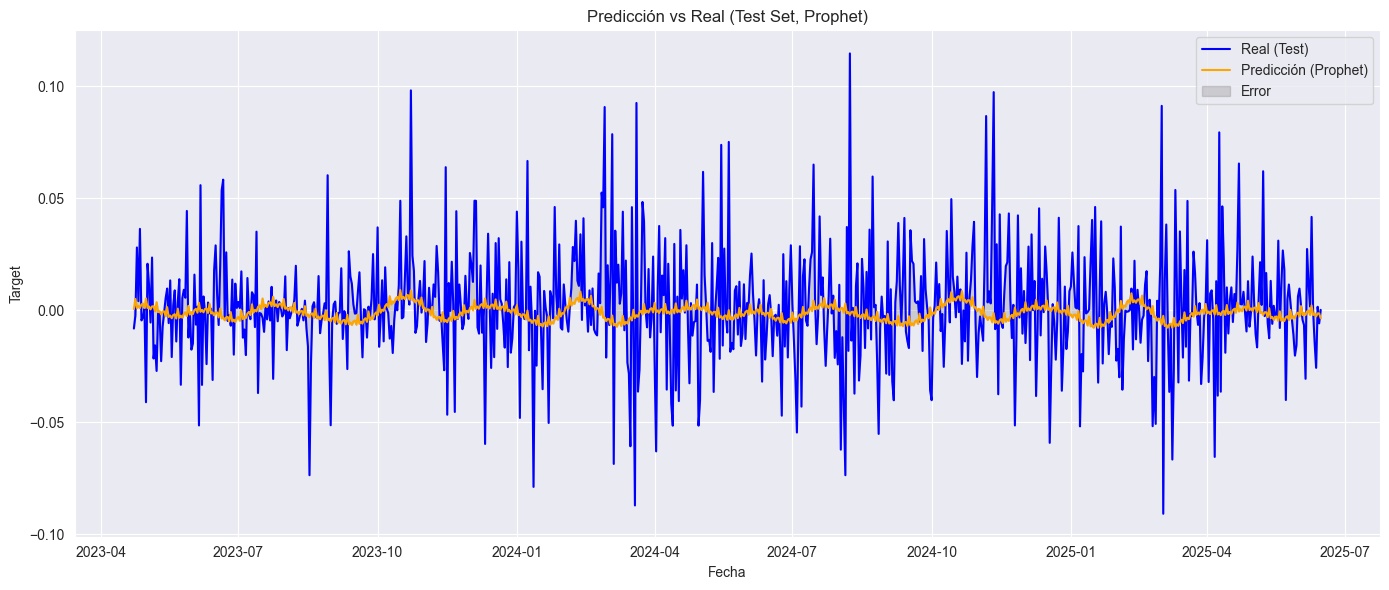

In [13]:
data, train, test = datasets(df, 'btc_log_return')
model = Prophet(n_changepoints=100, changepoint_range=1.0)
model.fit(train)
plot_prophet(data, test, model, plot_name="prophet_log_return")

Vemos un claro underfitting en el análisis. Es muy posible que Prophet no logre captar comportamientos repetitivos o estacionales por la gran varianza y outliers en los datos.

Haremos la prueba ahora con el precio directamente

13:38:44 - cmdstanpy - INFO - Chain [1] start processing
13:38:46 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE Prophet:  16792.762796
📊 RMSE Prophet: 22049.479113


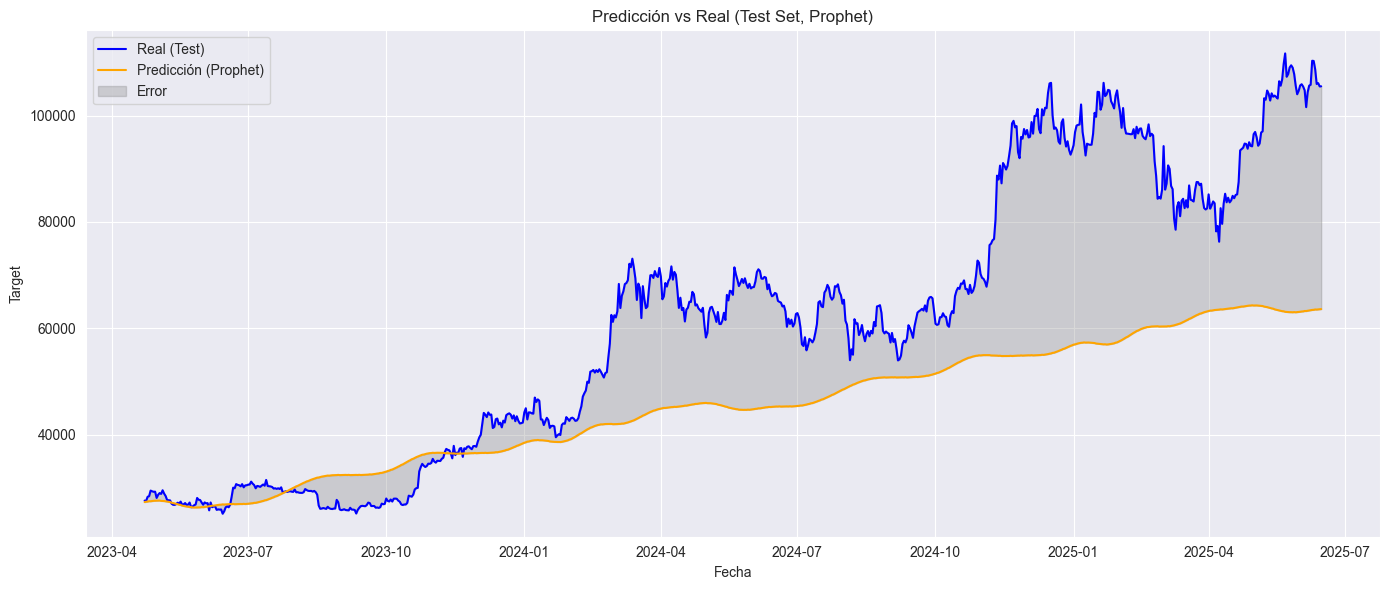

In [18]:
data, train, test = datasets(df, 'btc_close')
model = Prophet(n_changepoints=100, changepoint_range=1.0)
model.fit(train)
plot_prophet(data, test, model, plot_name="prophet_close")

Ahora haremos un análisis haciendo un estudio multivariado. Para ello primero escalaremos los precios de las demás criptomonedas

In [15]:
regresores = ['eth_close', 'fear_greed', 'sp500_close', 'gold_close', 'dxy_close']
df_scaled = df.copy()
scaler = StandardScaler()
valid_rows = df_scaled[regresores].dropna().index
df_scaled.loc[valid_rows, regresores] = scaler.fit_transform(df_scaled.loc[valid_rows, regresores])
df_scaled[regresores].describe()

,eth_close,fear_greed,sp500_close,gold_close,dxy_close
count,2776.000000,2.692000e+03,3925.000000,3925.000000,3925.000000
mean,22.483293,-1.266941e-16,690.870870,384.139185,30.045437
std,138.849082,1.000186e+00,1028.193908,569.078017,44.458083
min,-1.213050,-1.938977e+00,-1.738699,-1.442584,-1.922256
25%,-1.041879,-8.842136e-01,-0.538027,-0.247852,-0.439327
50%,0.050665,-1.288728e-02,0.519826,0.230982,0.794923
75%,0.849255,8.584391e-01,2041.319946,1164.900024,93.360001
max,1396.420044,2.188358e+00,2872.870117,1364.900024,103.290001


13:38:03 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE Prophet:  0.019750
📊 RMSE Prophet: 0.027371


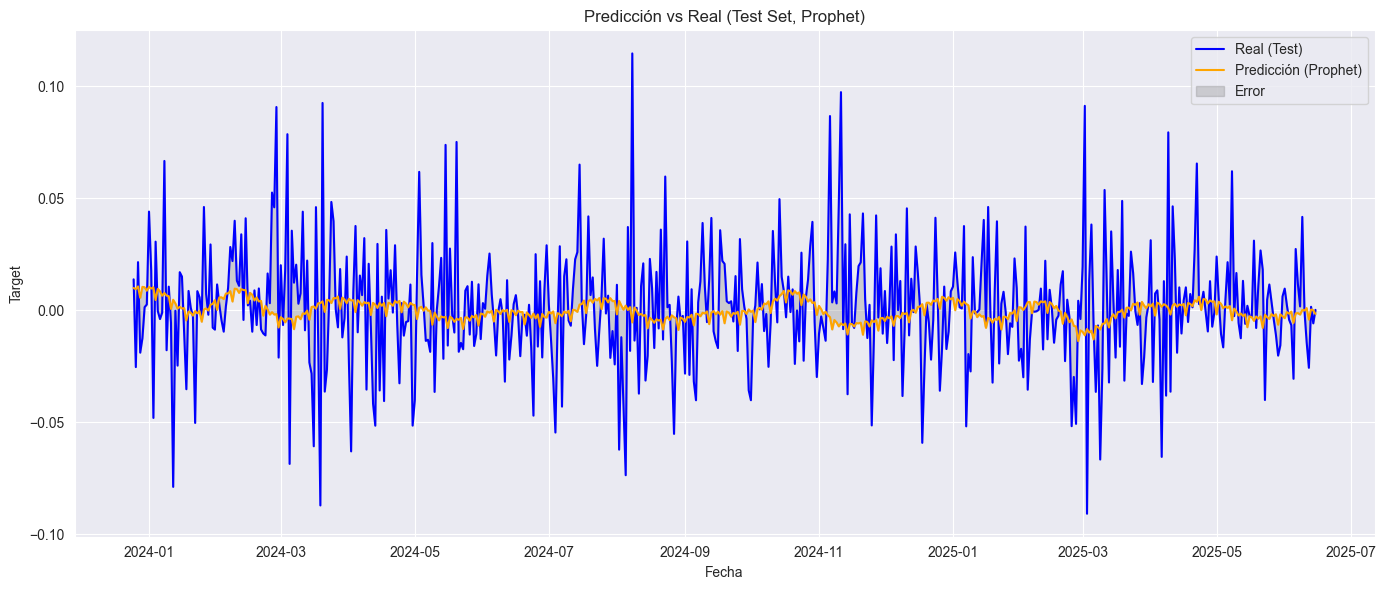

In [16]:
data, train, test = datasets(df_scaled, 'btc_log_return', regresores=regresores)

model = Prophet(n_changepoints=100, changepoint_range=1.0)
for reg in regresores:
    model.add_regressor(reg)

model.fit(train)
plot_prophet(data, test, model, regresores=regresores)

13:38:04 - cmdstanpy - INFO - Chain [1] start processing
13:38:07 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE Prophet:  6486.345880
📊 RMSE Prophet: 8325.107942


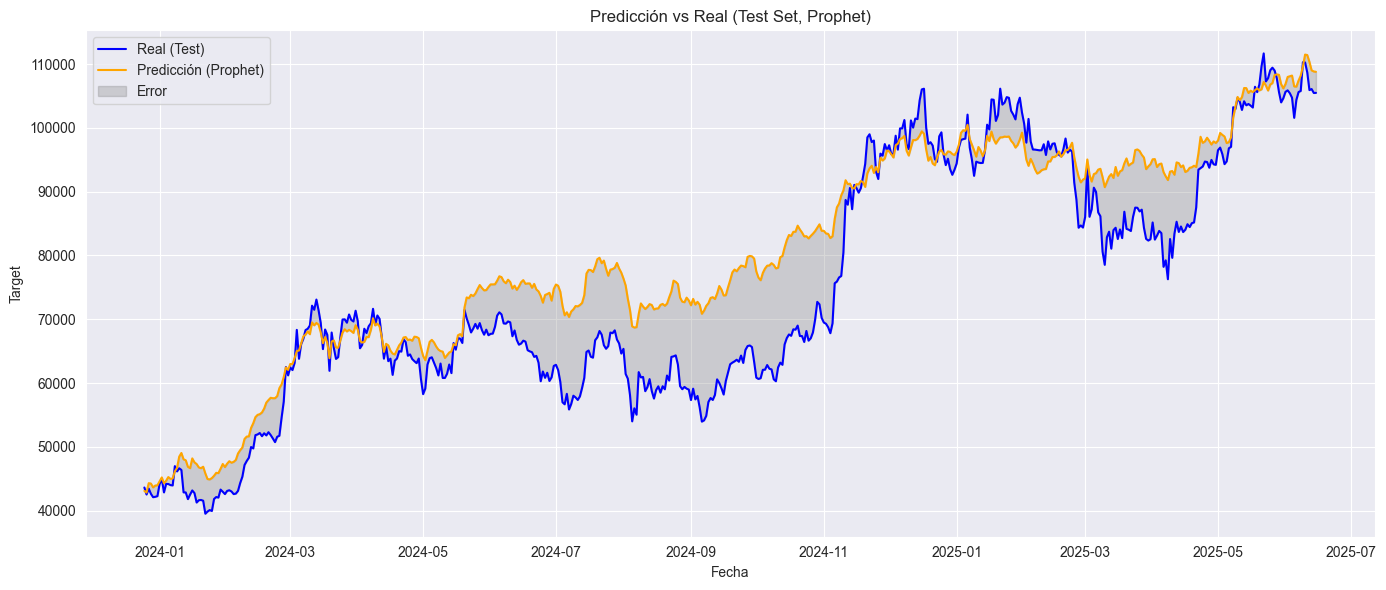

In [17]:
data, train, test = datasets(df_scaled, 'btc_close', regresores=regresores)

model = Prophet(n_changepoints=100, changepoint_range=1.0)
for reg in regresores:
    model.add_regressor(reg)

model.fit(train)
plot_prophet(data, test, model, regresores=regresores)